# Final project for "How to win a data science competition" Coursera course

Author: _Nasca, Matías_

(Part 2/2)
_______________

## Content

### [5. Modeling](#5.-Modeling)

    - 5.1. Access to data
    - 5.2. Scaling
    - 5.3. Dimensionality reduction
    - 5.4 Ensembling
    
### [6. Predictions](#6.-Predictions)

    - 6.1. Weigthed Averaging
    - 6.2. Stacking

### [7. Improvements](#7.-Improvements)

In [1]:
#DEPENDENCIES

#generall & utils
import os
import gc
import warnings

#data analysis
import numpy as np
import pandas as pd

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#data preprocesses
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

#machine learning
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.externals import joblib

/home/matias/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
#IPYTHON CONFIGURATIONS
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

plt.style.use('ggplot')
#%matplotlib inline
from tqdm import tqdm_notebook

%load_ext autoreload
%autoreload 2

## 5. Modeling

### 5.1. Access to data

In [3]:
PREPROCESS_PATH = './data/preprocess/'
X_train = pd.read_csv(os.path.join(PREPROCESS_PATH,'data_train.csv'))
X_test = pd.read_csv(os.path.join(PREPROCESS_PATH,'data_test.csv'))

y_train = pd.read_csv(os.path.join(PREPROCESS_PATH,'y_train.csv'))
y_test = pd.read_csv(os.path.join(PREPROCESS_PATH,'y_test.csv'))

# drop id_columns (for training)
month_train = X_train['date_block_num']
month_test = X_test['date_block_num']
id_columns = ['shop_id','item_id','item_category_id','date_block_num']
features = [x for x in X_train.columns if x not in id_columns]
X_train = X_train[features]
X_test = X_test[features]

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (1507264, 89)
y_train shape:  (1507264, 1)
X_test shape:  (214200, 89)
y_test shape:  (214200, 1)


In [4]:
#wrong values check
print('Check np.nan: ', np.any(np.isnan(X_train)))
print('Check np.inf: ', ~np.all(np.isfinite(X_train)))

Check np.nan:  True
Check np.inf:  True


In [5]:
#filling np.nan values
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

for col in X_train.columns:
    mean_col = X_train[col].mean()
    X_train[col] = X_train[col].fillna(mean_col)
    X_test[col] = X_test[col].fillna(mean_col)

#sanity check
print('Check np.nan: ', np.any(np.isnan(X_train)))
print('Check np.inf: ', ~np.all(np.isfinite(X_train)))

Check np.nan:  False
Check np.inf:  False


### 5.2. Scaling

In [6]:
# Standard scaling
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

del X_train, X_test, scaler
gc.collect();

### 5.3. Dimensionality reduction

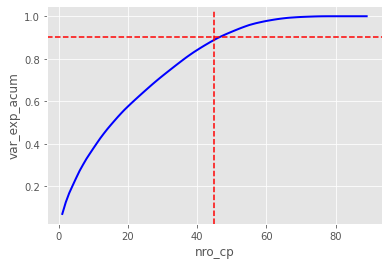

In [7]:
#PCA
pca = PCA().fit(X_train_scaled) 
var_exp = pca.explained_variance_ratio_
var_exp_acum = np.cumsum(var_exp)

#DataFrame 
lista_var = []
for i in range(X_train_scaled.shape[1]):
    dict_var={'nro_cp':i+1, 'var_exp':var_exp[i],'var_exp_acum':var_exp_acum[i]}
    lista_var.append(dict_var)    
df_var = pd.DataFrame(lista_var)

#Plot - Varianza explicada acumulada
sns.lineplot(data=df_var, x='nro_cp',y='var_exp_acum', color='blue',lw=2)
plt.axhline(0.9, xmax=36, color="r", linestyle="--") #varianza explicada elegida
plt.axvline(45, ymax=0.98, color="r", linestyle="--")
plt.show()
#plt.savefig('reducción de dimensionalidad.png') #exportar imagen

del df_var, pca, var_exp, var_exp_acum, lista_var
gc.collect();

In [8]:
#According above figure, for an explained variability of 90%, it is enough with 45 components 
pca = PCA(n_components=45, whiten=True, random_state=42)
model_pca = pca.fit(X_train_scaled)
X_train_scaled_pca = model_pca.transform(X_train_scaled)
X_test_scaled_pca  = model_pca.transform(X_test_scaled)

pca_cols = []
for col in range(X_train_scaled_pca.shape[1]):
    pca_col = 'pca_'+str(col)
    pca_cols.append(pca_col)

X_train_scaled_pca = pd.DataFrame(X_train_scaled_pca, columns=pca_cols)
X_test_scaled_pca = pd.DataFrame(X_test_scaled_pca, columns=pca_cols)


print('X_train reduced shape: ',X_train_scaled_pca.shape)
print('X_test reduced shape: ',X_test_scaled_pca.shape)

del X_train_scaled, X_test_scaled, model_pca
gc.collect();

X_train reduced shape:  (1507264, 45)
X_test reduced shape:  (214200, 45)


### 5.4 Ensembling
(KFold scheme Time Series)

In [9]:
target_range = [0, 20]

- **TEST META-FEATURES**

In [10]:
%%time
#LINEAR REGRESSION(OLS)
#model fitting
lr_model = LinearRegression()
lr_model.fit(X_train_scaled_pca, y_train)

#model prediction
pred_test_lr = lr_model.predict(X_test_scaled_pca).clip(*target_range)

#save model
MODEL_PATH = './model/'
joblib.dump(lr_model, os.path.join(MODEL_PATH,'lr_model.pkl'))

CPU times: user 6.48 s, sys: 240 ms, total: 6.72 s
Wall time: 4.58 s


['./model/lr_model.pkl']

In [11]:
%%time
#BOOSTING(LightGBM regressor)
#model fitting
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':1 
              }
lgb_train = lgb.Dataset(X_train_scaled_pca, y_train)
lgb_model = lgb.train(lgb_params, lgb_train, num_boost_round=100)

#model prediction
pred_test_lgb = lgb_model.predict(X_test_scaled_pca).clip(*target_range)

#save model
MODEL_PATH = './model/'
joblib.dump(lgb_model, os.path.join(MODEL_PATH,'lgb_model.pkl'))

CPU times: user 1min 4s, sys: 641 ms, total: 1min 4s
Wall time: 1min 6s


['./model/lgb_model.pkl']

In [12]:
#test predictions to get test meta-features
pred_test_lr = pred_test_lr.astype(np.float16)
pred_test_lgb = pred_test_lgb.astype(np.float16)
X_test_level2 = np.c_[pred_test_lr, pred_test_lgb]

- **TRAIN META-FEATURES**

In [13]:
meta_data_train = month_train[month_train >= month_train.min()+1] #months:26,27,28,29,30
y_train_level2 = y_train[month_train.isin(meta_data_train)]
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

print('y_train_level2 shape: ',y_train_level2.shape)
print('X_train_level2 shape: ',X_train_level2.shape)
print('Meta data train: ',set(meta_data_train))

y_train_level2 shape:  (1222773, 1)
X_train_level2 shape:  (1222773, 2)
Meta data train:  {26, 27, 28, 29, 30}


In [14]:
%%time
pbar = tqdm_notebook(meta_data_train.unique())
for cur_block_num in pbar:
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
        2. Fit linear regression 
        3. Fit LightGBM          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
    '''      
    
    pbar.set_description('{}: Split'.format(cur_block_num))
    _X_train = X_train_scaled_pca.loc[month_train <  cur_block_num]
    _X_test =  X_train_scaled_pca.loc[month_train == cur_block_num]

    _y_train = y_train.loc[month_train <  cur_block_num]
    _y_test =  y_train.loc[month_train == cur_block_num]
    
    pbar.set_description('{}: LR'.format(cur_block_num))
    lr = LinearRegression()
    lr.fit(_X_train, _y_train)
    X_train_level2[meta_data_train == cur_block_num, 0] = np.squeeze(lr.predict(_X_test).clip(*target_range))
    
    pbar.set_description('{}: LGB'.format(cur_block_num))
    lgb_train = lgb.Dataset(_X_train, label=_y_train)
    model = lgb.train(lgb_params, lgb_train, 100)
    X_train_level2[meta_data_train == cur_block_num, 1] = model.predict(_X_test).clip(*target_range)
    
del _X_train, _X_test, _y_train, _y_test, lr, model, meta_data_train
gc.collect();

26
27
28
29
30

CPU times: user 3min 27s, sys: 1.44 s, total: 3min 28s
Wall time: 3min 30s


83

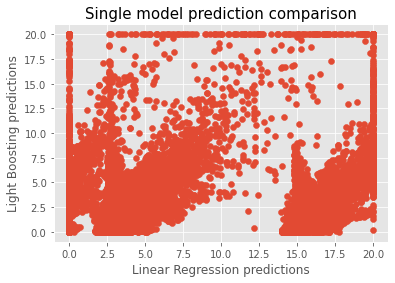

In [15]:
#check single model prediction comparison
plt.scatter(X_train_level2[:, 0], X_train_level2[:, 1])
plt.xlabel('Linear Regression predictions')
plt.ylabel('Light Boosting predictions')
plt.title('Single model prediction comparison', size=15)
plt.show()

## 6. Predictions

### 6.1. Weigthed Averaging

$$
mix= \alpha\cdot\text{linreg_prediction}+(1-\alpha)\cdot\text{lgb_prediction}
$$




In [16]:
alphas_to_try = np.linspace(0, 1, 1001)

r2_scores = np.array([r2_score(y_train_level2, np.dot(X_train_level2, [alpha, 1 - alpha])) for alpha in alphas_to_try])
best_alpha = alphas_to_try[r2_scores.argmax()]
r2_wavg = r2_scores.max()

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_wavg))

del alphas_to_try, r2_scores, r2_wavg
gc.collect();

Best alpha: 0.000000; Corresponding r2 score on train: 0.104417


In [17]:
test_preds = np.squeeze(best_alpha * pred_test_lr) + (1 - best_alpha) * pred_test_lgb

DATA_PATH = './data/raw/'
test = pd.read_csv(os.path.join(DATA_PATH,'test.csv'),usecols=['ID'],dtype = np.uint16)
test['item_cnt_month'] = test_preds
test.to_csv('submission_waveraging.csv', index=False)

del test
gc.collect();

### 6.2. Stacking

- **TRAIN META-MODEL**
(linear regression)

In [18]:
%%time
#training
meta_model_lr = LinearRegression()
meta_model_lr.fit(X_train_level2, y_train_level2)

CPU times: user 87.8 ms, sys: 0 ns, total: 87.8 ms
Wall time: 90 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
#performance evluation
train_preds = meta_model_lr.predict(X_train_level2).clip(*target_range)
r2_train_stacking = r2_score(y_train_level2, train_preds)

test_preds = meta_model_lr.predict(np.vstack((np.squeeze(pred_test_lr), pred_test_lgb)).T).clip(*target_range)
DATA_PATH = './data/raw/'
test = pd.read_csv(os.path.join(DATA_PATH,'test.csv'),usecols=['ID'],dtype = np.uint16)
test['item_cnt_month'] = test_preds
test.to_csv('submission_stacking.csv', index=False)

print('Train R-squared for stacking is %f' % r2_train_stacking)

del test
gc.collect();

Train R-squared for stacking is 0.093810


## 7. Improvements

In [20]:
### Missing imputations methods
### Add feature interacctions
### Perform rigurous variable selection
### Hyperparameters optimization
### Probe new single models and ensemble methods